In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Exploratory Data Analysis


### What data we have?

-- Shop description, what it sells, link etc ZHENYOK ADD IT HERE

In [191]:
df = pd.read_csv('data/all_months_combined.csv')
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('date')

### Basic info about data

In [192]:
print("\n1.1 Dataset Shape:")
print(f"   - Number of records: {len(df)}")
print(f"   - Number of features: {len(df.columns)}")
print(f"   - Date range: {df['date'].min().strftime('%B %Y')} to {df['date'].max().strftime('%B %Y')}")
print(f"   - Time span: {(df['date'].max() - df['date'].min()).days // 30} months")

print("\n1.2 Missing Values:")
print("-"*40)
missing = df.isnull().sum()

for col, count in missing[missing > 0].items():
    print(f"   {col}: {count} ({count/len(df)*100:.2f}%)")



1.1 Dataset Shape:
   - Number of records: 790
   - Number of features: 13
   - Date range: October 2017 to September 2025
   - Time span: 96 months

1.2 Missing Values:
----------------------------------------
   supplier_sum: 14 (1.77%)
   return_qty: 43 (5.44%)
   return_cost: 43 (5.44%)
   return_sum: 43 (5.44%)


Missing values mean 0 – 0 returns or 0 products sold so we are inserting 0 instead of none

In [193]:
return_cols = ['return_qty', 'return_cost', 'return_sum']
df[return_cols] = df[return_cols].fillna(0)
df['supplier_sum'] = df['supplier_sum'].fillna(0)

### Product categories analysis

In [194]:
categories = df['category'].unique()
print(f"\n2.1 Product Categories ({len(categories)} total):")
for i, cat in enumerate(categories, 1):
    total_revenue = df[df['category'] == cat]['revenue'].sum()
    print(f"   {i}. {cat:20s} - Total Revenue: {total_revenue:,.2f} UAH")


2.1 Product Categories (13 total):
   1. Іграшки              - Total Revenue: 1,587,508.06 UAH
   2. Творчість            - Total Revenue: 1,776,324.94 UAH
   3. Спорт                - Total Revenue: 45.00 UAH
   4. Пакет                - Total Revenue: 1,714.93 UAH
   5. Наочні посібники     - Total Revenue: 133,099.45 UAH
   6. Музика               - Total Revenue: 2,884.93 UAH
   7. Наука                - Total Revenue: 106,483.51 UAH
   8. Книга                - Total Revenue: 4,591,972.78 UAH
   9. Канцтовари           - Total Revenue: 478,714.36 UAH
   10. Інші                 - Total Revenue: 16,250.10 UAH
   11. Ігри                 - Total Revenue: 1,108,446.12 UAH
   12. Конструктори         - Total Revenue: 808,646.80 UAH
   13. Органіка             - Total Revenue: 598.00 UAH


In [195]:
print("\n2.2 Category Performance Metrics:")
print("-"*40)
category_stats = df.groupby('category').agg({
    'revenue': ['sum', 'mean', 'std'],
    'profit': ['sum', 'mean'],
    'sold_qty': 'sum',
    'return_qty': 'sum'
}).round(2)
print(category_stats)


2.2 Category Performance Metrics:
----------------------------------------
                     revenue                          profit            \
                         sum      mean       std         sum      mean   
category                                                                 
Іграшки           1587508.06  23694.15  14011.45   640380.82   9557.92   
Ігри              1108446.12  11918.78   6933.98   456353.24   4907.02   
Інші                16250.10    325.00    462.09     7159.39    143.19   
Канцтовари         478714.36   5260.60   3548.77   222902.41   2449.48   
Книга             4591972.78  49376.05  20168.40  1680508.65  18069.99   
Конструктори       808646.80   8789.64   8453.64   315091.12   3424.90   
Музика               2884.93    221.92    217.83     1096.31     84.33   
Наочні посібники   133099.45   1446.73    958.04    51754.14    562.54   
Наука              106483.51   1238.18   1155.36    40832.07    474.79   
Органіка              598.00    299.

### Time series characteristics

In [196]:
monthly_data = df.groupby('date').agg({
    'revenue': 'sum',
    'profit': 'sum',
    'sold_qty': 'sum',
    'return_qty': 'sum',
    'sold_cost': 'sum'
}).reset_index()

print("\n3.1 Monthly Revenue Statistics:")
print(f"   - Mean monthly revenue: {monthly_data['revenue'].mean():,.2f} UAH")
print(f"   - Median monthly revenue: {monthly_data['revenue'].median():,.2f} UAH")
print(f"   - Std deviation: {monthly_data['revenue'].std():,.2f} UAH")
print(f"   - Min monthly revenue: {monthly_data['revenue'].min():,.2f} UAH")
print(f"   - Max monthly revenue: {monthly_data['revenue'].max():,.2f} UAH")
print(f"   - Coefficient of Variation: {(monthly_data['revenue'].std()/monthly_data['revenue'].mean())*100:.2f}%")

print("\n3.2 Growth Rates:")
monthly_data['revenue_growth'] = monthly_data['revenue'].pct_change() * 100
avg_growth = monthly_data['revenue_growth'].mean()
print(f"   - Average monthly growth rate: {avg_growth:.2f}%")
print(f"   - Median growth rate: {monthly_data['revenue_growth'].median():.2f}%")
print(f"   - Growth volatility (std): {monthly_data['revenue_growth'].std():.2f}%")



3.1 Monthly Revenue Statistics:
   - Mean monthly revenue: 114,114.94 UAH
   - Median monthly revenue: 102,935.00 UAH
   - Std deviation: 60,117.58 UAH
   - Min monthly revenue: 1,435.00 UAH
   - Max monthly revenue: 391,261.44 UAH
   - Coefficient of Variation: 52.68%

3.2 Growth Rates:
   - Average monthly growth rate: 86.61%
   - Median growth rate: 2.57%
   - Growth volatility (std): 530.77%


### Seasonality 

In [197]:
# Extract month for seasonality
df['month_name'] = pd.to_datetime(df['date']).dt.strftime('%B')
df['month_num'] = df['month']

seasonal_revenue = df.groupby('month_num')['revenue'].agg(['mean', 'std', 'count'])
seasonal_revenue = seasonal_revenue.sort_index()

print("\n4.1 Average Revenue by Month:")
print("-"*40)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month_num in seasonal_revenue.index:
    if month_num <= 12:
        mean_rev = seasonal_revenue.loc[month_num, 'mean']
        std_rev = seasonal_revenue.loc[month_num, 'std']
        count = seasonal_revenue.loc[month_num, 'count']
        print(f"   {months[month_num-1]:3s}: Mean={mean_rev:8,.0f} UAH, Std={std_rev:8,.0f}, n={count:.0f}")

# Find peak and low seasons
peak_month = seasonal_revenue['mean'].idxmax()
low_month = seasonal_revenue['mean'].idxmin()
print(f"\n   📈 Peak season: {months[peak_month-1]} (avg: {seasonal_revenue.loc[peak_month, 'mean']:,.0f} UAH)")
print(f"   📉 Low season: {months[low_month-1]} (avg: {seasonal_revenue.loc[low_month, 'mean']:,.0f} UAH)")



4.1 Average Revenue by Month:
----------------------------------------
   Jan: Mean=  12,739 UAH, Std=  15,344, n=72
   Feb: Mean=  12,030 UAH, Std=  15,680, n=72
   Mar: Mean=  12,405 UAH, Std=  15,238, n=59
   Apr: Mean=   8,134 UAH, Std=  11,992, n=54
   May: Mean=   9,734 UAH, Std=  13,338, n=66
   Jun: Mean=  10,296 UAH, Std=  13,730, n=67
   Jul: Mean=  10,344 UAH, Std=  12,225, n=65
   Aug: Mean=  11,388 UAH, Std=  13,722, n=55
   Sep: Mean=  13,715 UAH, Std=  16,411, n=67
   Oct: Mean=  13,919 UAH, Std=  16,310, n=71
   Nov: Mean=  13,529 UAH, Std=  16,300, n=71
   Dec: Mean=  30,415 UAH, Std=  32,860, n=71

   📈 Peak season: Dec (avg: 30,415 UAH)
   📉 Low season: Apr (avg: 8,134 UAH)


We can see clear annual pattern across 8 years

### Profitability

In [198]:

# Calculate profit margins
df['profit_margin'] = (df['profit'] / df['revenue']) * 100
overall_margin = (df['profit'].sum() / df['revenue'].sum()) * 100

print(f"\n5.1 Overall Profit Metrics:")
print(f"   - Total Revenue: {df['revenue'].sum():,.2f} UAH")
print(f"   - Total Profit: {df['profit'].sum():,.2f} UAH")
print(f"   - Overall Profit Margin: {overall_margin:.2f}%")

print("\n5.2 Profit Margins by Category:")
print("-"*40)
category_margins = df.groupby('category').apply(
    lambda x: (x['profit'].sum() / x['revenue'].sum() * 100) if x['revenue'].sum() > 0 else 0
).sort_values(ascending=False)

for cat, margin in category_margins.items():
    print(f"   {cat:20s}: {margin:.2f}%")



5.1 Overall Profit Metrics:
   - Total Revenue: 10,612,688.98 UAH
   - Total Profit: 4,177,534.46 UAH
   - Overall Profit Margin: 39.36%

5.2 Profit Margins by Category:
----------------------------------------
   Пакет               : 51.24%
   Спорт               : 47.62%
   Канцтовари          : 46.56%
   Інші                : 44.06%
   Творчість           : 42.81%
   Ігри                : 41.17%
   Іграшки             : 40.34%
   Конструктори        : 38.97%
   Наочні посібники    : 38.88%
   Наука               : 38.35%
   Музика              : 38.00%
   Книга               : 36.60%
   Органіка            : 30.42%


Profit margin stable at 39.36%

### Return

In [199]:
total_returns = df['return_qty'].sum()
total_sold = df['sold_qty'].sum()
return_rate = (total_returns / total_sold) * 100

print(f"\n6.1 Overall Return Statistics:")
print(f"   - Total items sold: {total_sold:,.0f}")
print(f"   - Total items returned: {total_returns:,.0f}")
print(f"   - Overall return rate: {return_rate:.2f}%")

print("\n6.2 Returns by Category:")
print("-"*40)
category_returns = df.groupby('category').apply(
    lambda x: (x['return_qty'].sum() / x['sold_qty'].sum() * 100) if x['sold_qty'].sum() > 0 else 0
).sort_values(ascending=False)

for cat, rate in category_returns[category_returns > 0].items():
    qty_returned = df[df['category'] == cat]['return_qty'].sum()
    print(f"   {cat:20s}: {rate:.2f}% ({qty_returned:.0f} items)")



6.1 Overall Return Statistics:
   - Total items sold: 103,181
   - Total items returned: 437
   - Overall return rate: 0.42%

6.2 Returns by Category:
----------------------------------------
   Наука               : 1.52% (8 items)
   Конструктори        : 0.81% (17 items)
   Наочні посібники    : 0.72% (24 items)
   Іграшки             : 0.58% (63 items)
   Книга               : 0.38% (174 items)
   Канцтовари          : 0.38% (49 items)
   Творчість           : 0.37% (70 items)
   Ігри                : 0.36% (32 items)


### Visualizations

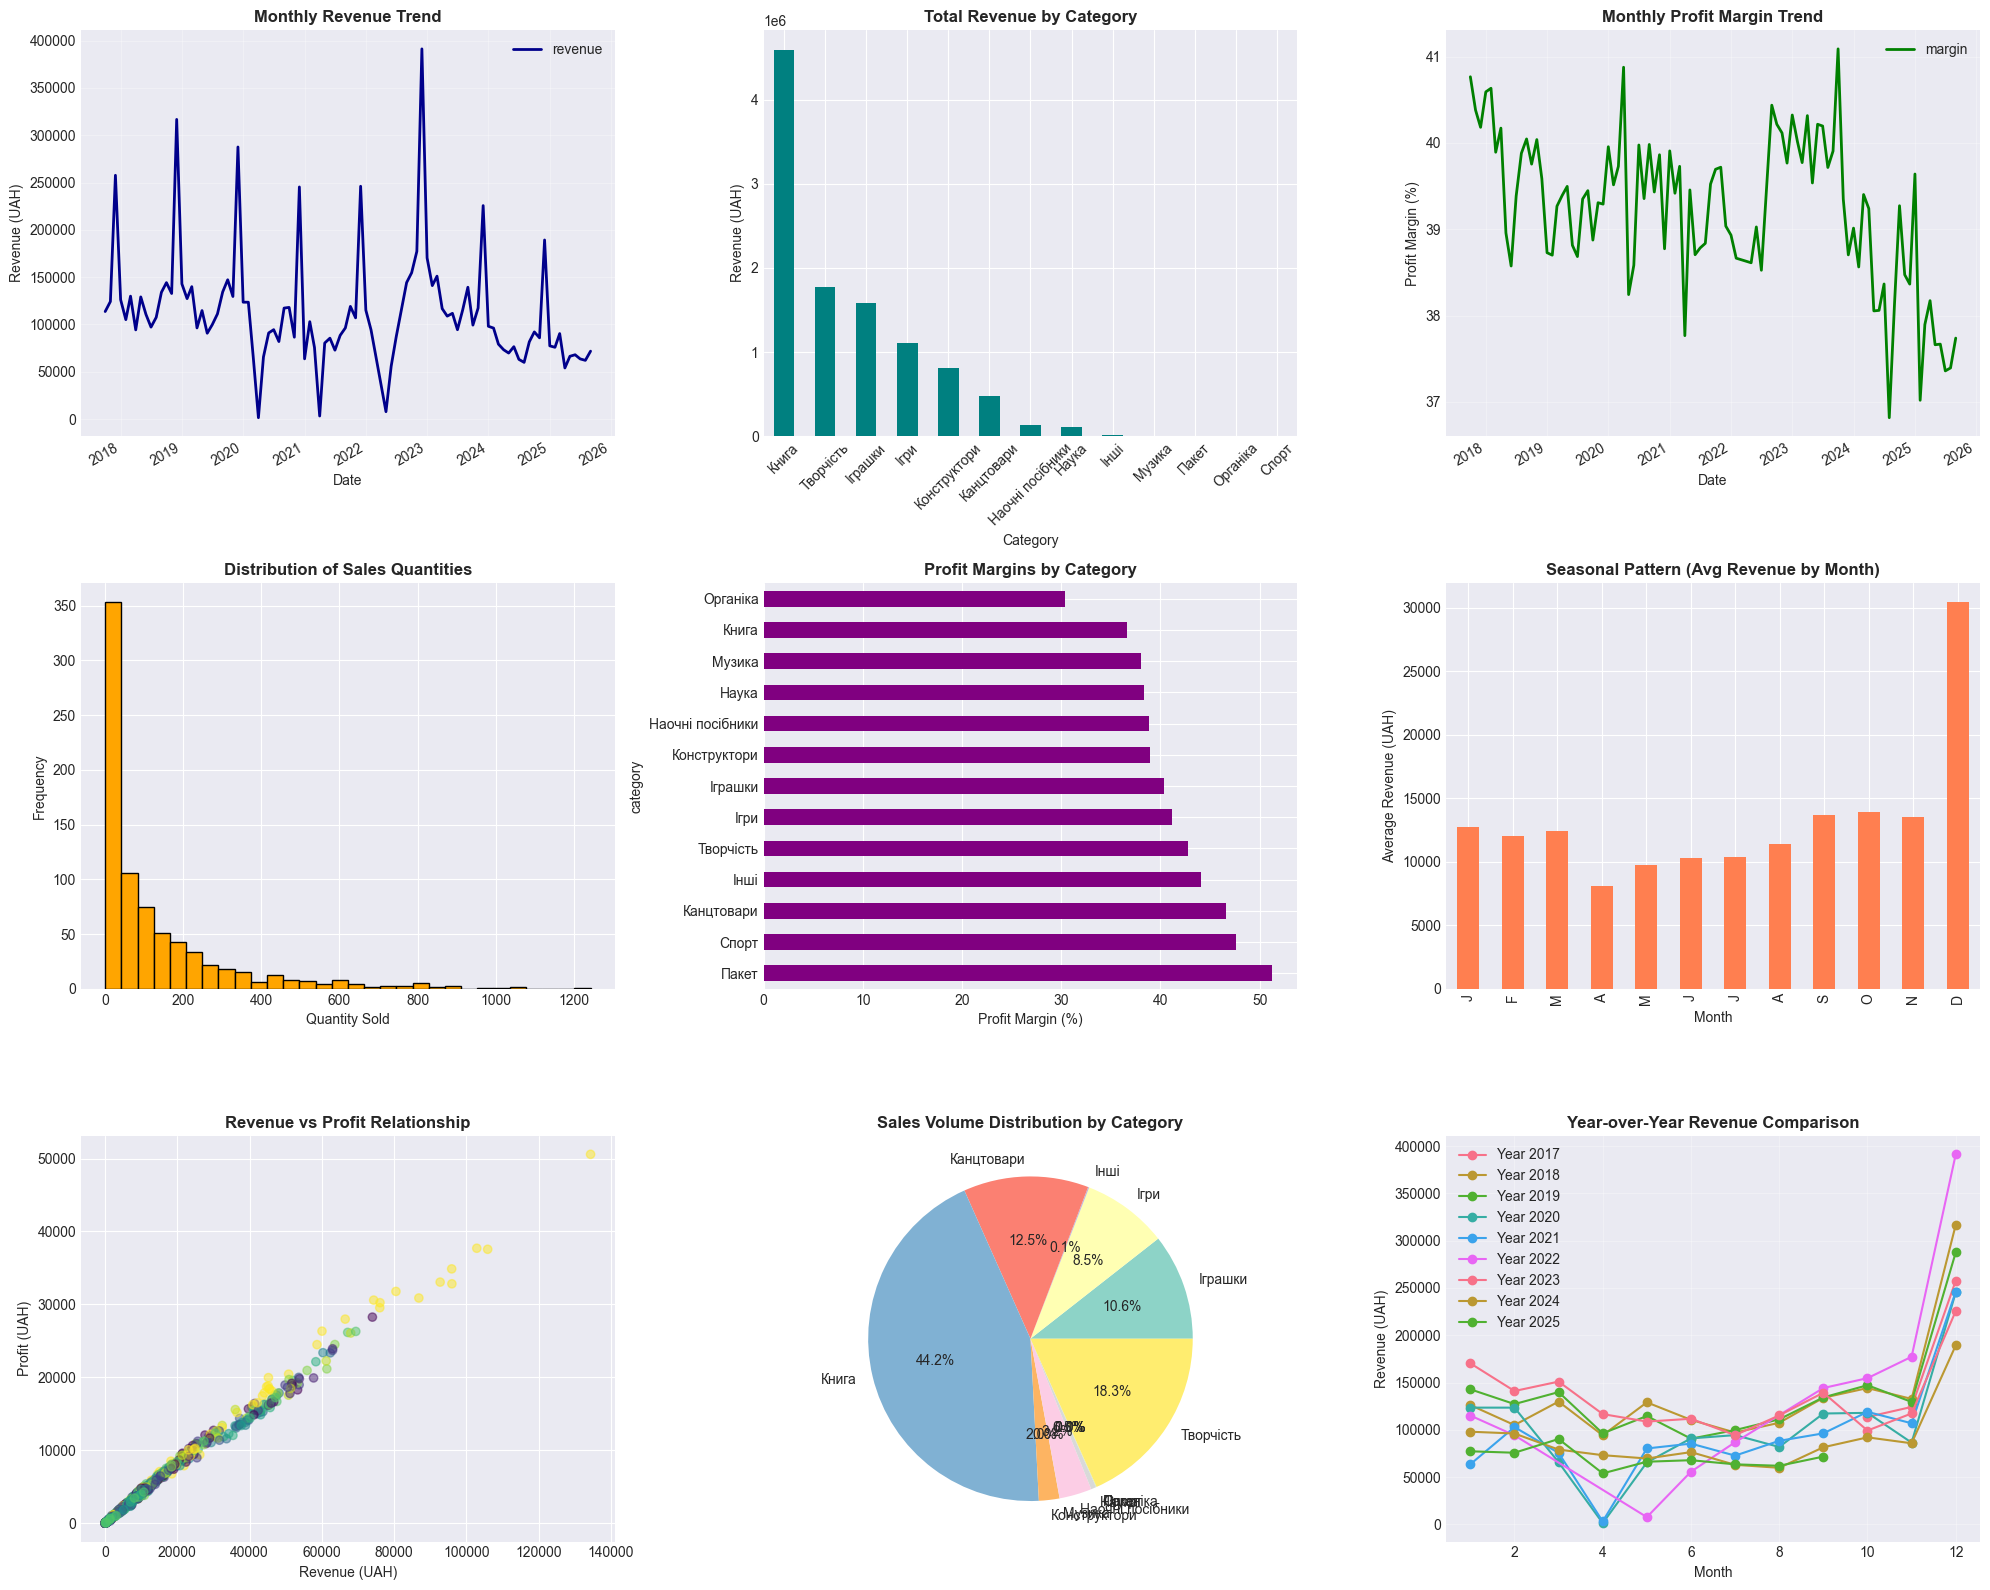

In [200]:
fig = plt.figure(figsize=(20, 16))

# 1. Monthly Revenue Trend
ax1 = plt.subplot(3, 3, 1)
monthly_data.plot(x='date', y='revenue', ax=ax1, color='darkblue', linewidth=2)
ax1.set_title('Monthly Revenue Trend', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Revenue (UAH)')
ax1.grid(True, alpha=0.3)

# 2. Revenue by Category (Bar)
ax2 = plt.subplot(3, 3, 2)
category_revenue = df.groupby('category')['revenue'].sum().sort_values(ascending=False)
category_revenue.plot(kind='bar', ax=ax2, color='teal')
ax2.set_title('Total Revenue by Category', fontsize=12, fontweight='bold')
ax2.set_xlabel('Category')
ax2.set_ylabel('Revenue (UAH)')
ax2.tick_params(axis='x', rotation=45)

# 3. Monthly Profit Margin Trend
ax3 = plt.subplot(3, 3, 3)
monthly_margin = monthly_data.copy()
monthly_margin['margin'] = (monthly_margin['profit'] / monthly_margin['revenue']) * 100
monthly_margin.plot(x='date', y='margin', ax=ax3, color='green', linewidth=2)
ax3.set_title('Monthly Profit Margin Trend', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Profit Margin (%)')
ax3.grid(True, alpha=0.3)

# 4. Sales Quantity Distribution
ax4 = plt.subplot(3, 3, 4)
df['sold_qty'].hist(bins=30, ax=ax4, color='orange', edgecolor='black')
ax4.set_title('Distribution of Sales Quantities', fontsize=12, fontweight='bold')
ax4.set_xlabel('Quantity Sold')
ax4.set_ylabel('Frequency')

# 5. Category Profit Margins
ax5 = plt.subplot(3, 3, 5)
category_margins.plot(kind='barh', ax=ax5, color='purple')
ax5.set_title('Profit Margins by Category', fontsize=12, fontweight='bold')
ax5.set_xlabel('Profit Margin (%)')

# 6. Seasonal Pattern (Average Revenue by Month)
ax6 = plt.subplot(3, 3, 6)
seasonal_pattern = df.groupby('month')['revenue'].mean().sort_index()
seasonal_pattern.plot(kind='bar', ax=ax6, color='coral')
ax6.set_title('Seasonal Pattern (Avg Revenue by Month)', fontsize=12, fontweight='bold')
ax6.set_xlabel('Month')
ax6.set_ylabel('Average Revenue (UAH)')
ax6.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

# 7. Revenue vs Profit Scatter
ax7 = plt.subplot(3, 3, 7)
ax7.scatter(df['revenue'], df['profit'], alpha=0.5, c=df['month'], cmap='viridis')
ax7.set_title('Revenue vs Profit Relationship', fontsize=12, fontweight='bold')
ax7.set_xlabel('Revenue (UAH)')
ax7.set_ylabel('Profit (UAH)')

# 8. Category Sales Volume Pie Chart
ax8 = plt.subplot(3, 3, 8)
category_qty = df.groupby('category')['sold_qty'].sum()
colors = plt.cm.Set3(range(len(category_qty)))
ax8.pie(category_qty, labels=category_qty.index, autopct='%1.1f%%', colors=colors)
ax8.set_title('Sales Volume Distribution by Category', fontsize=12, fontweight='bold')

# 9. Year-over-Year Comparison (if applicable)
ax9 = plt.subplot(3, 3, 9)
yearly_revenue = df.groupby(['year', 'month']).agg({'revenue': 'sum'}).reset_index()
for year in yearly_revenue['year'].unique():
    year_data = yearly_revenue[yearly_revenue['year'] == year]
    ax9.plot(year_data['month'], year_data['revenue'], marker='o', label=f'Year {year}')
ax9.set_title('Year-over-Year Revenue Comparison', fontsize=12, fontweight='bold')
ax9.set_xlabel('Month')
ax9.set_ylabel('Revenue (UAH)')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Outliers analysis

In results we see that we have not only seasonality but outliers also. lets investigate this situation:

Q1: 1237.53, Q3: 17438.64, IQR: 16201.11
Bounds: [-23064.15, 41740.31]

Total outliers: 75 (9.49%)

Outliers by month:
month
12    24
2      7
9      7
10     7
11     6
1      5
3      5
6      5
5      3
8      3
7      2
4      1
dtype: int64


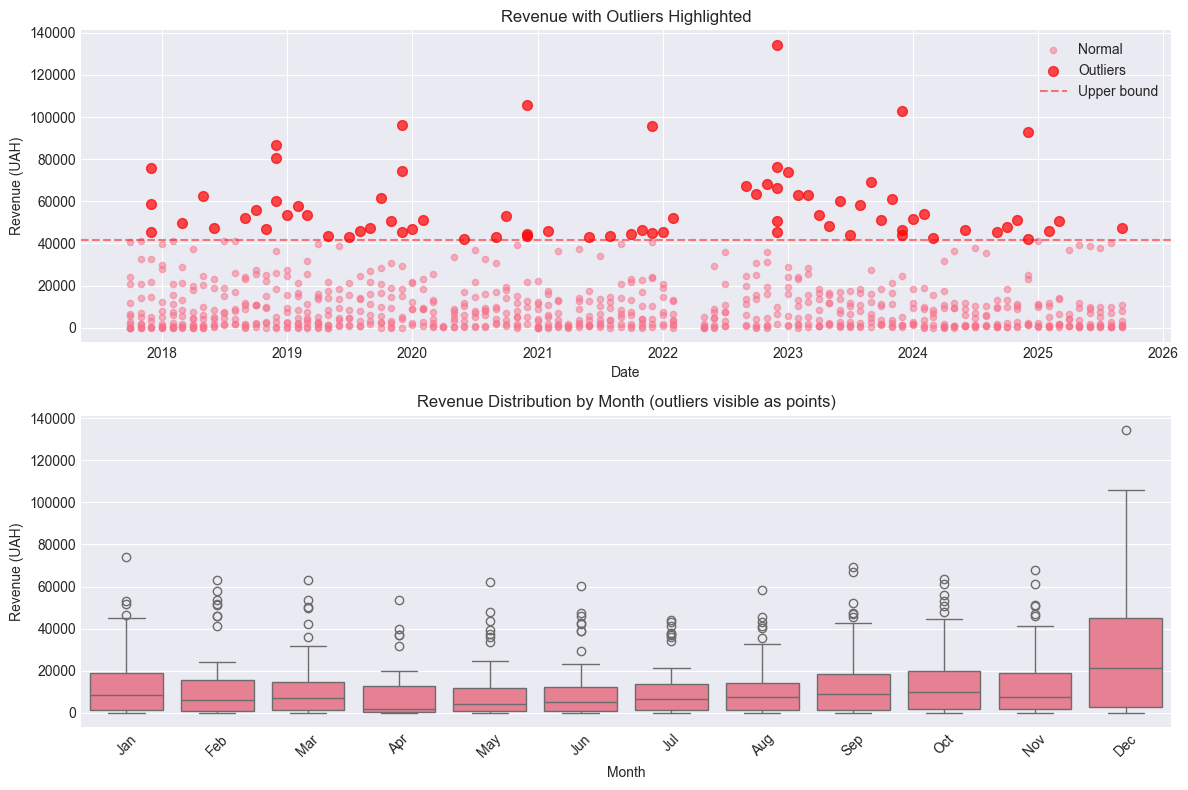


Top 10 highest outliers:
          date    revenue category
520 2022-12-01  134405.63    Книга
346 2020-12-01  105916.90    Книга
620 2023-12-01  102898.66    Книга
254 2019-12-01   96003.96    Книга
447 2021-12-01   95950.15    Книга
714 2024-12-01   92753.51    Книга
144 2018-12-01   86860.07    Книга
140 2018-12-01   80513.18  Іграшки
517 2022-12-01   76098.12  Іграшки
27  2017-12-01   76036.90    Книга


In [201]:
Q1 = df['revenue'].quantile(0.25)
Q3 = df['revenue'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

df['is_outlier'] = (df['revenue'] < lower_bound) | (df['revenue'] > upper_bound)
outliers = df[df['is_outlier']]

print(f"\nTotal outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

df['month'] = pd.to_datetime(df['date']).dt.month
outliers_by_month = outliers.groupby('month').size()

print("\nOutliers by month:")
print(outliers_by_month.sort_values(ascending=False))

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].scatter(df[~df['is_outlier']]['date'], df[~df['is_outlier']]['revenue'], 
                alpha=0.5, s=20, label='Normal')
axes[0].scatter(outliers['date'], outliers['revenue'], 
                color='red', s=50, alpha=0.7, label='Outliers')
axes[0].axhline(y=upper_bound, color='r', linestyle='--', alpha=0.5, label='Upper bound')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenue (UAH)')
axes[0].set_title('Revenue with Outliers Highlighted')
axes[0].legend()

df['month_name'] = pd.to_datetime(df['date']).dt.strftime('%b')
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.boxplot(data=df, x='month_name', y='revenue', order=month_order, ax=axes[1])
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Revenue (UAH)')
axes[1].set_title('Revenue Distribution by Month (outliers visible as points)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nTop 10 highest outliers:")
print(outliers.nlargest(10, 'revenue')[['date', 'revenue', 'category']])

### Conclusions

Based on EDA we can make some conclusions:

- Our data is strongly seasonal: December is 3.7x higher than April. Model absolutely needs to capture this seasonal pattern (maybe SARIMA or smt).

- Series are pretty noisy: CV of 52.68% and crazy growth volatility (530.77%). We might need smoothing.

- Outliers are seasonal – mostly january sales. 

- The growth rates stats (86% mean but 2.57% median) suggest we have some extreme months skewing things.

Good to know:

- Returns are negligible (0.42%) - won't affect forecasts

- Product mix is stable with Books + Art as main drivers


# Baseline – SARIMA

In [202]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

monthly_data = df.groupby(['year', 'month'])['revenue'].sum().reset_index()
monthly_data['date'] = pd.to_datetime(
    monthly_data['year'].astype(str) + '-' + 
    monthly_data['month'].astype(str) + '-01'
)
monthly_data = monthly_data.sort_values('date').set_index('date')

ts = monthly_data['revenue']

print(f"Data: {len(ts)} months from {ts.index[0]} to {ts.index[-1]}")


Data: 93 months from 2017-10-01 00:00:00 to 2025-09-01 00:00:00


In [203]:
train_size = len(ts) - 12
train = ts[:train_size]
test = ts[train_size:]

print(f"Train: {len(train)} months, Test: {len(test)} months")

Train: 81 months, Test: 12 months


## Exploratory analysis

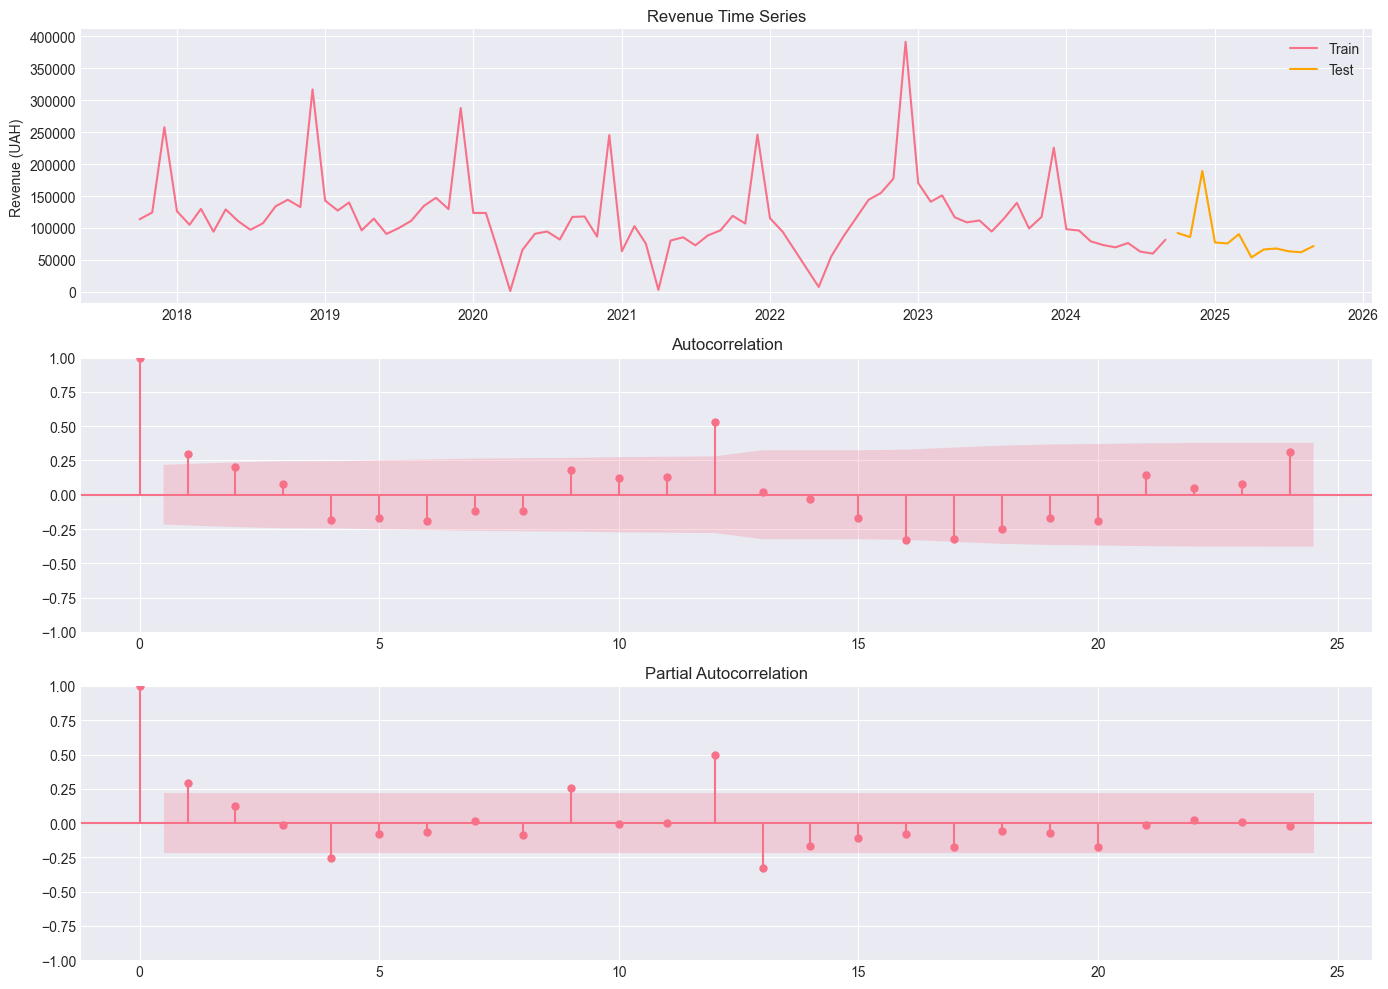

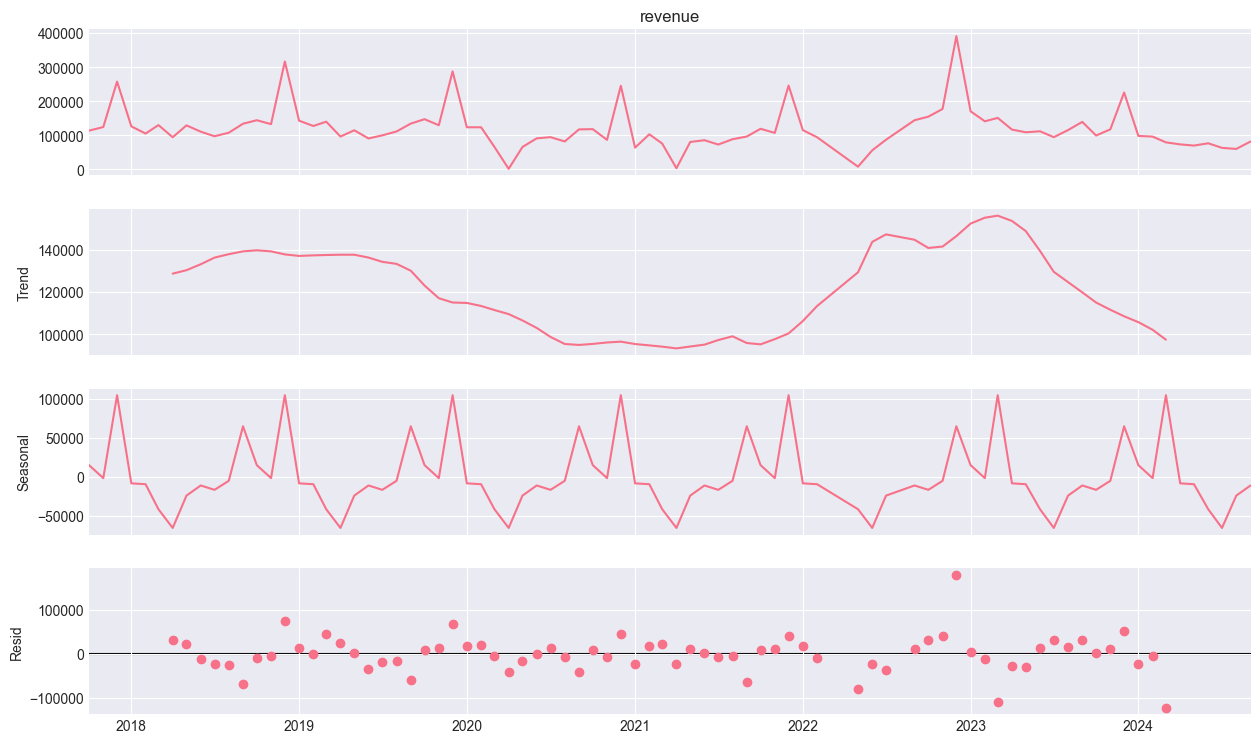

In [204]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(train.index, train.values, label='Train')
axes[0].plot(test.index, test.values, label='Test', color='orange')
axes[0].set_title('Revenue Time Series')
axes[0].legend()
axes[0].set_ylabel('Revenue (UAH)')

plot_acf(train, lags=24, ax=axes[1])
plot_pacf(train, lags=24, ax=axes[2])

plt.tight_layout()
plt.show()

decomposition = seasonal_decompose(train, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()


In [205]:
def evaluate_sarima(train, test, order, seasonal_order):
    """trains and evaluates SARIMA model"""
    try:
        model = SARIMAX(train, 
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        
        fitted_model = model.fit(disp=False, maxiter=200)
        forecast = fitted_model.forecast(steps=len(test))

        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = mean_absolute_percentage_error(test, forecast) * 100
        
        return {
            'model': fitted_model,
            'forecast': forecast,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'aic': fitted_model.aic,
            'bic': fitted_model.bic
        }
    except:
        return None


## Full grid search

Total configurations to test: 216
This may take a few minutes...



Non-seasonal params: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


✅ Successfully fitted: 215 models
❌ Failed: 0 models

TOP 10 MODELS BY MAPE:
SARIMA(2, 1, 2)x(2, 0, 0, 12): MAPE=8.99%, MAE=6783.93, AIC=1339.78
SARIMA(1, 1, 2)x(2, 0, 0, 12): MAPE=10.06%, MAE=7679.01, AIC=1362.89
SARIMA(2, 0, 0)x(2, 0, 0, 12): MAPE=10.41%, MAE=8669.14, AIC=1359.58
SARIMA(1, 0, 1)x(2, 0, 0, 12): MAPE=10.50%, MAE=8681.09, AIC=1381.95
SARIMA(2, 0, 2)x(2, 0, 0, 12): MAPE=10.60%, MAE=8881.01, AIC=1362.81
SARIMA(1, 0, 0)x(1, 0, 1, 12): MAPE=10.70%, MAE=8069.20, AIC=1680.85
SARIMA(0, 0, 0)x(1, 0, 0, 12): MAPE=10.99%, MAE=8585.93, AIC=1708.42
SARIMA(2, 0, 1)x(2, 0, 0, 12): MAPE=11.15%, MAE=9592.58, AIC=1358.97
SARIMA(2, 0, 2)x(1, 0, 1, 12): MAPE=11.77%, MAE=9574.83, AIC=1626.28
SARIMA(1, 1, 1)x(2, 0, 0, 12): MAPE=11.89%, MAE=9091.95, AIC=1360.47

TOP 10 MODELS BY AIC:
SARIMA(2, 1, 1)x(2, 1, 1, 12): AIC=1047.60, MAPE=27.24%, MAE=26087.88
SARIMA(2, 1, 2)x(2, 1, 1, 12): AIC=1048.91, MAPE=23.57%, MAE=23487.32
SARIMA(2, 1, 2)x(2, 1, 0, 12): AIC=1049.50, MAPE=30.44%, MAE=27069.87


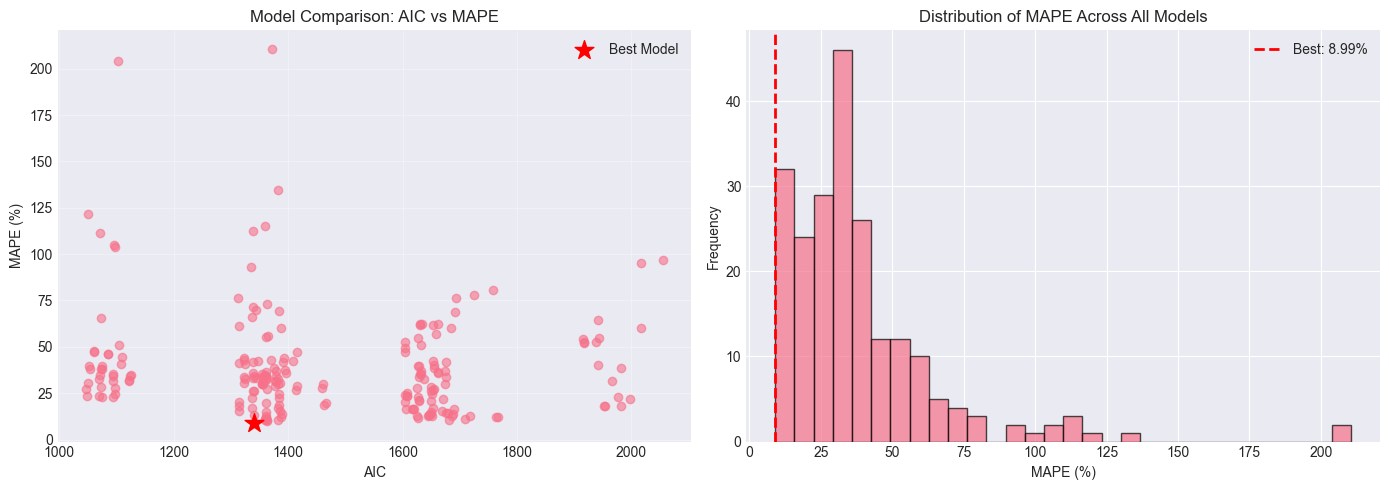


📊 Full results saved to 'sarima_grid_search_results.csv'


In [206]:
import itertools
from tqdm import tqdm 

p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1]
S = 12

pdq_combinations = list(itertools.product(p_values, d_values, q_values))
PDQ_combinations = list(itertools.product(P_values, D_values, Q_values, [S]))

total_combinations = len(pdq_combinations) * len(PDQ_combinations)
print(f"Total configurations to test: {total_combinations}")
print("This may take a few minutes...\n")

results = []
failed_configs = []

for pdq in tqdm(pdq_combinations, desc="Non-seasonal params"):
    for PDQ in PDQ_combinations:
        try:
        
        
            if pdq == (0, 0, 0) and PDQ == (0, 0, 0, 12):
                continue
                
            model = SARIMAX(train, 
                           order=pdq,
                           seasonal_order=PDQ,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
            
            fitted_model = model.fit(disp=False, maxiter=200, method='lbfgs')
            
        
            forecast = fitted_model.forecast(steps=len(test))
            
        
            mae = mean_absolute_error(test, forecast)
            rmse = np.sqrt(mean_squared_error(test, forecast))
            mape = mean_absolute_percentage_error(test, forecast) * 100
            
            results.append({
                'order': pdq,
                'seasonal_order': PDQ,
                'model': fitted_model,
                'forecast': forecast,
                'mae': mae,
                'rmse': rmse,
                'mape': mape,
                'aic': fitted_model.aic,
                'bic': fitted_model.bic
            })
            
        except Exception as e:
            failed_configs.append({
                'order': pdq,
                'seasonal_order': PDQ,
                'error': str(e)
            })
            continue

print(f"\n✅ Successfully fitted: {len(results)} models")
print(f"❌ Failed: {len(failed_configs)} models")

results_df = pd.DataFrame([{
    'order': r['order'],
    'seasonal_order': r['seasonal_order'],
    'mape': r['mape'],
    'mae': r['mae'],
    'rmse': r['rmse'],
    'aic': r['aic'],
    'bic': r['bic']
} for r in results])

print("\n" + "="*60)
print("TOP 10 MODELS BY MAPE:")
print("="*60)
top_mape = results_df.nsmallest(10, 'mape')
for idx, row in top_mape.iterrows():
    print(f"SARIMA{row['order']}x{row['seasonal_order']}: "
          f"MAPE={row['mape']:.2f}%, MAE={row['mae']:.2f}, "
          f"AIC={row['aic']:.2f}")

print("\n" + "="*60)
print("TOP 10 MODELS BY AIC:")
print("="*60)
top_aic = results_df.nsmallest(10, 'aic')
for idx, row in top_aic.iterrows():
    print(f"SARIMA{row['order']}x{row['seasonal_order']}: "
          f"AIC={row['aic']:.2f}, MAPE={row['mape']:.2f}%, "
          f"MAE={row['mae']:.2f}")

best_idx = results_df['mape'].idxmin()
best_result = results[best_idx]

print("\n" + "="*60)
print("BEST MODEL (by MAPE):")
print(f"SARIMA{best_result['order']}x{best_result['seasonal_order']}")
print(f"MAPE: {best_result['mape']:.2f}%")
print(f"MAE: {best_result['mae']:.2f}")
print(f"RMSE: {best_result['rmse']:.2f}")
print(f"AIC: {best_result['aic']:.2f}")
print(f"BIC: {best_result['bic']:.2f}")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(results_df['aic'], results_df['mape'], alpha=0.6)
axes[0].scatter(best_result['aic'], best_result['mape'], 
               color='red', s=200, marker='*', label='Best Model')
axes[0].set_xlabel('AIC')
axes[0].set_ylabel('MAPE (%)')
axes[0].set_title('Model Comparison: AIC vs MAPE')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(results_df['mape'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(best_result['mape'], color='red', linestyle='--', 
               linewidth=2, label=f"Best: {best_result['mape']:.2f}%")
axes[1].set_xlabel('MAPE (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of MAPE Across All Models')
axes[1].legend()

plt.tight_layout()
plt.show()

results_df.to_csv('sarima_grid_search_results.csv', index=False)
print("\n📊 Full results saved to 'sarima_grid_search_results.csv'")

The full search grid revealed that the more complex AR/MA components (2,1,2) and the AR seasonal conditions (P=2) without seasonal difference (D=0) give the best forecast accuracy (MAPE=8.99%). This indicates a stable multiplicative seasonality in the data. The model shows a significant improvement over the baseline configuration (MAPE 22% → 9%).

## Final SARIMA

In [211]:
best_order = (2, 1, 2)
best_seasonal_order = (2, 0, 0, 12)

final_model = SARIMAX(ts, 
                     order=best_order,
                     seasonal_order=best_seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

final_fitted = final_model.fit(disp=False, maxiter=200)

print(f"\nAIC: {final_fitted.aic:.2f}")
print(f"BIC: {final_fitted.bic:.2f}")



AIC: 1624.70
BIC: 1640.03


## Forecast

In [212]:
n_periods = 12
forecast = final_fitted.forecast(steps=n_periods)
forecast_obj = final_fitted.get_forecast(steps=n_periods)
forecast_ci = forecast_obj.conf_int()

last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                             periods=n_periods, 
                             freq='MS')

forecast_df = pd.DataFrame({
    'Month': future_dates.strftime('%Y-%m'),
    'Forecast': forecast.values,
    'Lower_95CI': forecast_ci.iloc[:, 0].values,
    'Upper_95CI': forecast_ci.iloc[:, 1].values
})

print("\n2026 Monthly Revenue Forecast:")
print(forecast_df.to_string(index=False))

print(f"\n2026 Forecast Summary:")
print(f"  Total annual revenue: {forecast.sum():,.2f} UAH")
print(f"  Average monthly revenue: {forecast.mean():,.2f} UAH")
print(f"  Peak month: {future_dates[forecast.argmax()].strftime('%B')} ({forecast.max():,.2f} UAH)")
print(f"  Low month: {future_dates[forecast.argmin()].strftime('%B')} ({forecast.min():,.2f} UAH)")



2026 Monthly Revenue Forecast:
  Month      Forecast     Lower_95CI    Upper_95CI
2025-10  70647.940340  -50070.617075 191366.497755
2025-11  71641.257534  -62119.151648 205401.666716
2025-12 143272.258843   -2787.764325 289332.282010
2026-01  64484.643805  -86169.375186 215138.662795
2026-02  63600.344632  -91783.599316 218984.288580
2026-03  67077.278031  -91276.929157 225431.485218
2026-04  48717.452078 -112676.866124 210111.770281
2026-05  53866.978726 -110036.305356 217770.262807
2026-06  56017.580276 -110411.318263 222446.478814
2026-07  51236.669205 -117527.073759 220000.412168
2026-08  49874.950504 -121214.795142 220964.696150
2026-09  58873.303703 -114460.039105 232206.646511

2026 Forecast Summary:
  Total annual revenue: 799,310.66 UAH
  Average monthly revenue: 66,609.22 UAH
  Peak month: December (143,272.26 UAH)
  Low month: April (48,717.45 UAH)


## Residual analysis

In [213]:
residuals = final_fitted.resid

# Basic statistics
print(f"\nResiduals Statistics:")
print(f"  Mean: {residuals.mean():.2f}")
print(f"  Std Dev: {residuals.std():.2f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")

# Normality tests
print("\nNormality Tests:")

# 1. Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"  Shapiro-Wilk test:")
print(f"    Statistic: {shapiro_stat:.4f}")
print(f"    p-value: {shapiro_p:.4f}")
print(f"    Result: {'Normal' if shapiro_p > 0.05 else 'Not Normal'} (at α=0.05)")

# 2. Jarque-Bera test
jb_stat, jb_p = stats.jarque_bera(residuals)
print(f"\n  Jarque-Bera test:")
print(f"    Statistic: {jb_stat:.4f}")
print(f"    p-value: {jb_p:.4f}")
print(f"    Result: {'Normal' if jb_p > 0.05 else 'Not Normal'} (at α=0.05)")

# 3. Anderson-Darling test
ad_result = stats.anderson(residuals, dist='norm')
print(f"\n  Anderson-Darling test:")
print(f"    Statistic: {ad_result.statistic:.4f}")
print(f"    Critical values: {ad_result.critical_values}")
print(f"    Result: {'Normal' if ad_result.statistic < ad_result.critical_values[2] else 'Not Normal'} (at 5% significance)")

# Skewness and Kurtosis
skewness = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals)
print(f"\n  Skewness: {skewness:.4f} (normal: 0)")
print(f"  Kurtosis: {kurtosis:.4f} (normal: 0)")



Residuals Statistics:
  Mean: -3085.11
  Std Dev: 45230.60
  Min: -101668.83
  Max: 235422.37

Normality Tests:
  Shapiro-Wilk test:
    Statistic: 0.8580
    p-value: 0.0000
    Result: Not Normal (at α=0.05)

  Jarque-Bera test:
    Statistic: 291.4153
    p-value: 0.0000
    Result: Not Normal (at α=0.05)

  Anderson-Darling test:
    Statistic: 2.7848
    Critical values: [0.554 0.631 0.757 0.883 1.05 ]
    Result: Not Normal (at 5% significance)

  Skewness: 1.8171 (normal: 0)
  Kurtosis: 7.8738 (normal: 0)


## Visualization

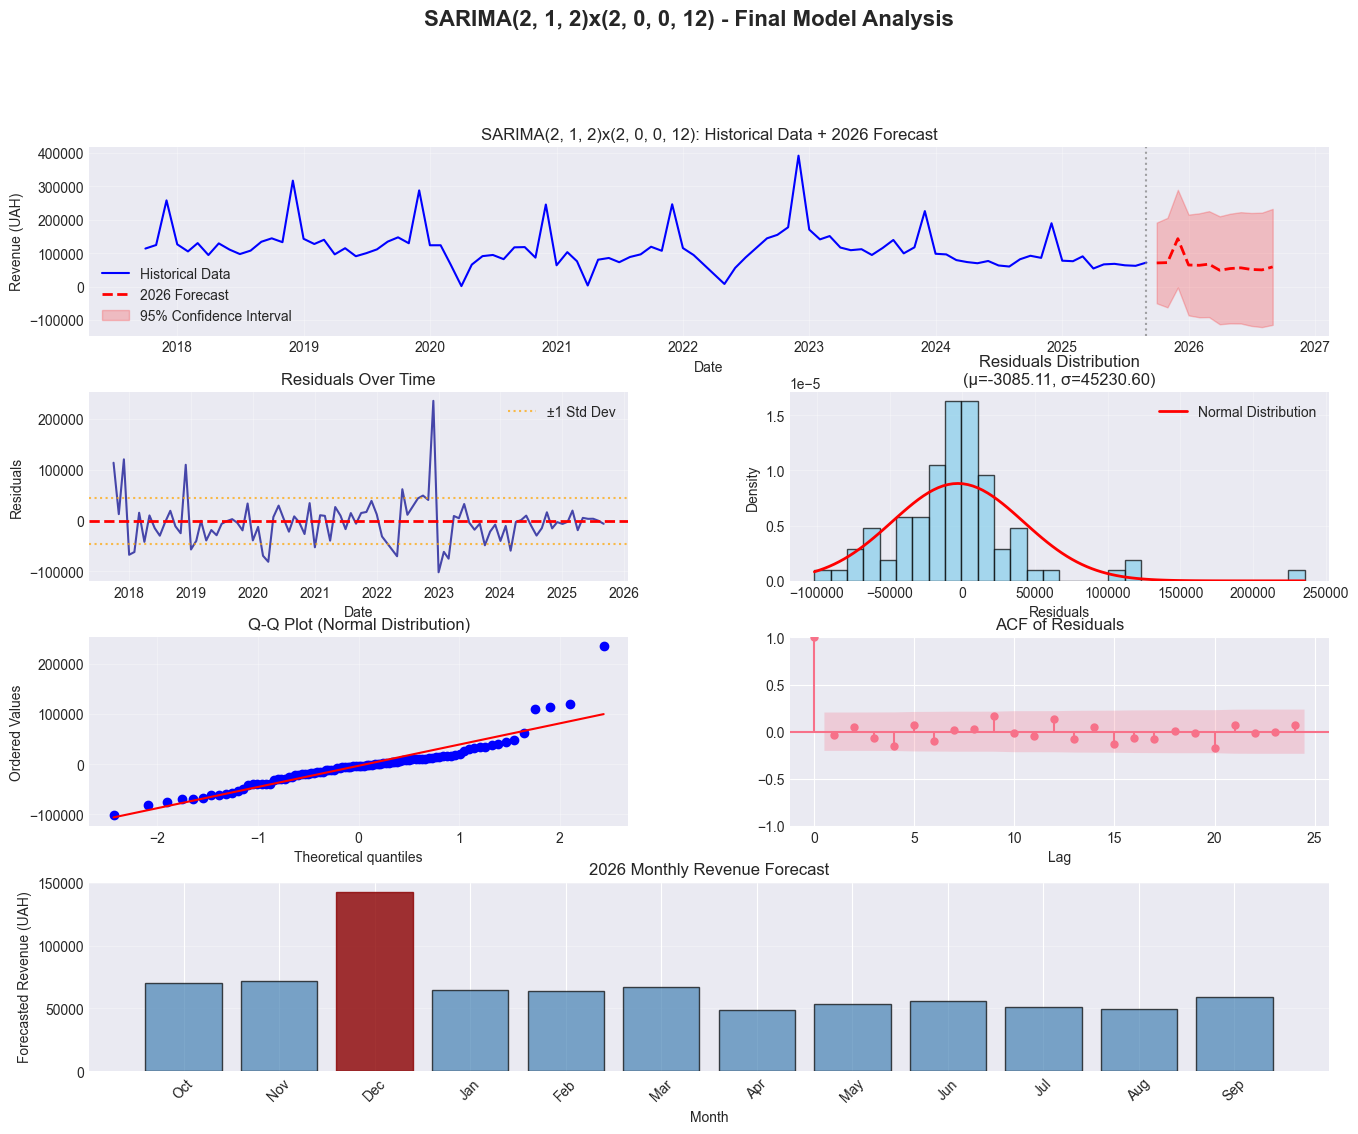

In [214]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# Plot 1: Historical + Forecast
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(ts.index, ts.values, label='Historical Data', color='blue', linewidth=1.5)
ax1.plot(future_dates, forecast.values, label='2026 Forecast', 
         color='red', linestyle='--', linewidth=2)
ax1.fill_between(future_dates, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 alpha=0.2, color='red', label='95% Confidence Interval')
ax1.axvline(x=ts.index[-1], color='gray', linestyle=':', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Revenue (UAH)')
ax1.set_title(f'SARIMA{best_order}x{best_seasonal_order}: Historical Data + 2026 Forecast')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Residuals over time
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(residuals.index, residuals.values, color='darkblue', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.axhline(y=residuals.std(), color='orange', linestyle=':', alpha=0.7, label='±1 Std Dev')
ax2.axhline(y=-residuals.std(), color='orange', linestyle=':', alpha=0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals Over Time')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Residuals histogram with normal curve
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
# Fit normal distribution
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
ax3.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Density')
ax3.set_title(f'Residuals Distribution\n(μ={mu:.2f}, σ={sigma:.2f})')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Q-Q plot
ax4 = fig.add_subplot(gs[2, 0])
stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Normal Distribution)')
ax4.grid(alpha=0.3)

# Plot 5: ACF of residuals
ax5 = fig.add_subplot(gs[2, 1])
plot_acf(residuals, lags=24, ax=ax5)
ax5.set_title('ACF of Residuals')
ax5.set_xlabel('Lag')

# Plot 6: Forecast by month (seasonal pattern)
ax6 = fig.add_subplot(gs[3, :])
months = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
ax6.bar(months, forecast.values, color='steelblue', alpha=0.7, edgecolor='black')
ax6.set_xlabel('Month')
ax6.set_ylabel('Forecasted Revenue (UAH)')
ax6.set_title('2026 Monthly Revenue Forecast')
ax6.grid(axis='y', alpha=0.3)
ax6.tick_params(axis='x', rotation=45)

# Highlight December
dec_idx = 2  # December is the 3rd month (Oct, Nov, Dec)
ax6.patches[dec_idx].set_color('darkred')
ax6.patches[dec_idx].set_alpha(0.8)

plt.suptitle(f'SARIMA{best_order}x{best_seasonal_order} - Final Model Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()


## Model summary

In [215]:
print(final_fitted.summary())


                                      SARIMAX Results                                      
Dep. Variable:                             revenue   No. Observations:                   93
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 12)   Log Likelihood                -805.351
Date:                             Sun, 02 Nov 2025   AIC                           1624.702
Time:                                     17:23:27   BIC                           1640.029
Sample:                                          0   HQIC                          1630.759
                                              - 93                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0351      1.328     -0.026      0.979      -2.637       2.567
ar.L2          0.3440      

## Conclusion

The SARIMA(2,1,2)x(2,0,0,12) model achieves strong predictive performance with MAPE=8.99%, 
successfully capturing the pronounced seasonal patterns in monthly revenue data. 

The Ljung-Box test (p=0.80) confirms no residual autocorrelation, validating that temporal structure has 
been adequately modeled. 

However, the model exhibits several limitations: 
- (1) all coefficients are statistically insignificant (p>0.10), suggesting potential over-parameterization; 
- (2) residuals violate normality assumptions (Jarque-Bera p<0.001, skewness=1.82, kurtosis=7.87), indicating a heavy-tailed distribution with more extreme values than expected; and 
- (3) heteroskedasticity is present (H=0.36, p=0.02). 

These violations mean that while point forecasts are reliable for operational planning, the 95% confidence intervals likely 
underestimate true forecast uncertainty. For retail revenue forecasting with high volatility 
(CV=52.68%), the model provides adequate accuracy, though variance-stabilizing transformations 
or robust methods could improve reliability of uncertainty estimates.
